In [308]:
import pandas as pd
import numpy as np
import yfinance as yf
import backtrader as bt
import seaborn as sns
from pylab import plt, mpl
from ysk_quantlib import *

plt.style.use('seaborn-v0_8-paper')
mpl.rcParams['font.serif'] = 'Times'
%matplotlib inline

In [309]:
arkk = pd.read_excel('ARKK.xlsx')

arkk['Date'] = pd.to_datetime(arkk['Date'])

arkk = arkk.set_index('Date')

arkk

,Close,High,Low,Open,Volume
Date,,,,,
2014-10-31,18.391508,18.427606,18.391508,18.427606,2700
2014-11-03,18.391508,18.490776,18.364436,18.490776,2300
2014-11-04,18.283218,18.292243,18.229073,18.229073,7900
2014-11-05,18.048588,18.508827,18.048588,18.508827,14900
2014-11-06,18.174929,18.174929,18.111759,18.129808,2000
...,...,...,...,...,...
2024-12-23,59.240002,59.680000,58.165001,59.520000,7760600
2024-12-24,60.959999,60.990002,59.439999,59.630001,4801700
2024-12-26,60.959999,61.134998,60.040001,60.720001,6885500


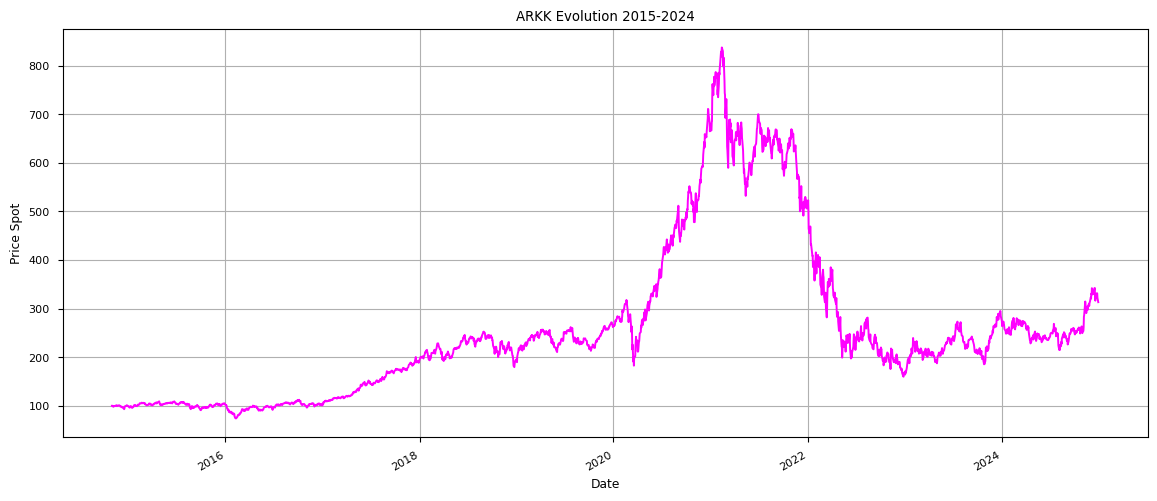

In [310]:
def normalize(data):
    return data['Close'] * 100 / data['Close'].iloc[0]

normalize(arkk).plot(figsize=(14,6), color = 'magenta');
plt.ylabel('Price Spot')
plt.title('ARKK Evolution 2015-2024')
plt.grid(True)
plt.show()

In [311]:
prices = arkk['Close']

In [312]:
returns = prices.pct_change().dropna()

returns.columns = ['ARKK']

In [313]:
stats_returns = returns.describe(include='all')

stats_returns

count    2556.000000
mean        0.000729
std         0.023730
min        -0.155711
25%        -0.010850
50%         0.001612
75%         0.012762
max         0.145226
Name: Close, dtype: float64

In [314]:
mu = returns.mean()
annualized_mu = ((1 + mu) ** 252) - 1

print(f'Daily return of ARKK: {mu * 100:.5f} %')
print(f'Annualized return of ARKK: {annualized_mu * 100:.5f} %')

Daily return of ARKK: 0.07289 %
Annualized return of ARKK: 20.15625 %


In [315]:
sigma = returns.std()
annualized_sigma = sigma * np.sqrt(252)

print(f'Daily volatility of ARKK: {sigma * 100:.5f} %')
print(f'Annualized volatility of ARKK: {annualized_sigma * 100:.5f} %')

Daily volatility of ARKK: 2.37300 %
Annualized volatility of ARKK: 37.67018 %


Jarque-Bera Statistic: 1185.2609
p-value: 0.0000
Conclusion: ❌ Not normally distributed


c:\Users\houss\anaconda3\Lib\site-packages\ysk_quantlib\stats.py:245: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\houss\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


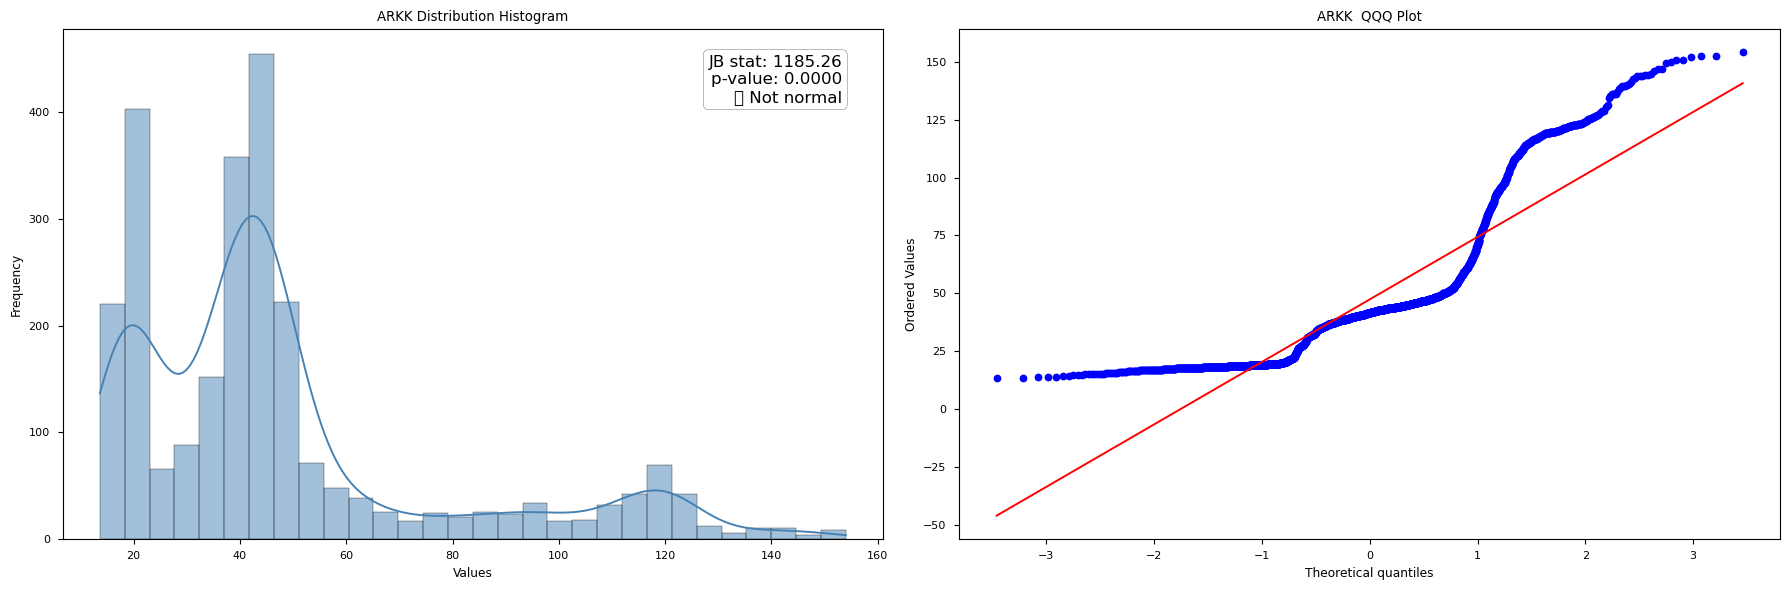

In [316]:
jb_test = jarque_bera_test(prices, verbose=True, plot=True, title_prefix='ARKK ')

In [317]:
adf = adf_test(prices, verbose=True)

                          Valeur
ADF Stat                 -1.4686
p-value                   0.5490
Lags Used                     26
Observations                2530
Critique 1%              -3.4329
Critique 5%              -2.8627
Critique 10%             -2.5674
Conclusion    ❌ Non stationnaire


In [318]:
pp = pp_test(prices, verbose=True)

Statistique PP: -1.4452
p-valeur: 0.5604
Retards utilisés: 27
Critique 10%: -2.5674
Conclusion: ❌ No stationary


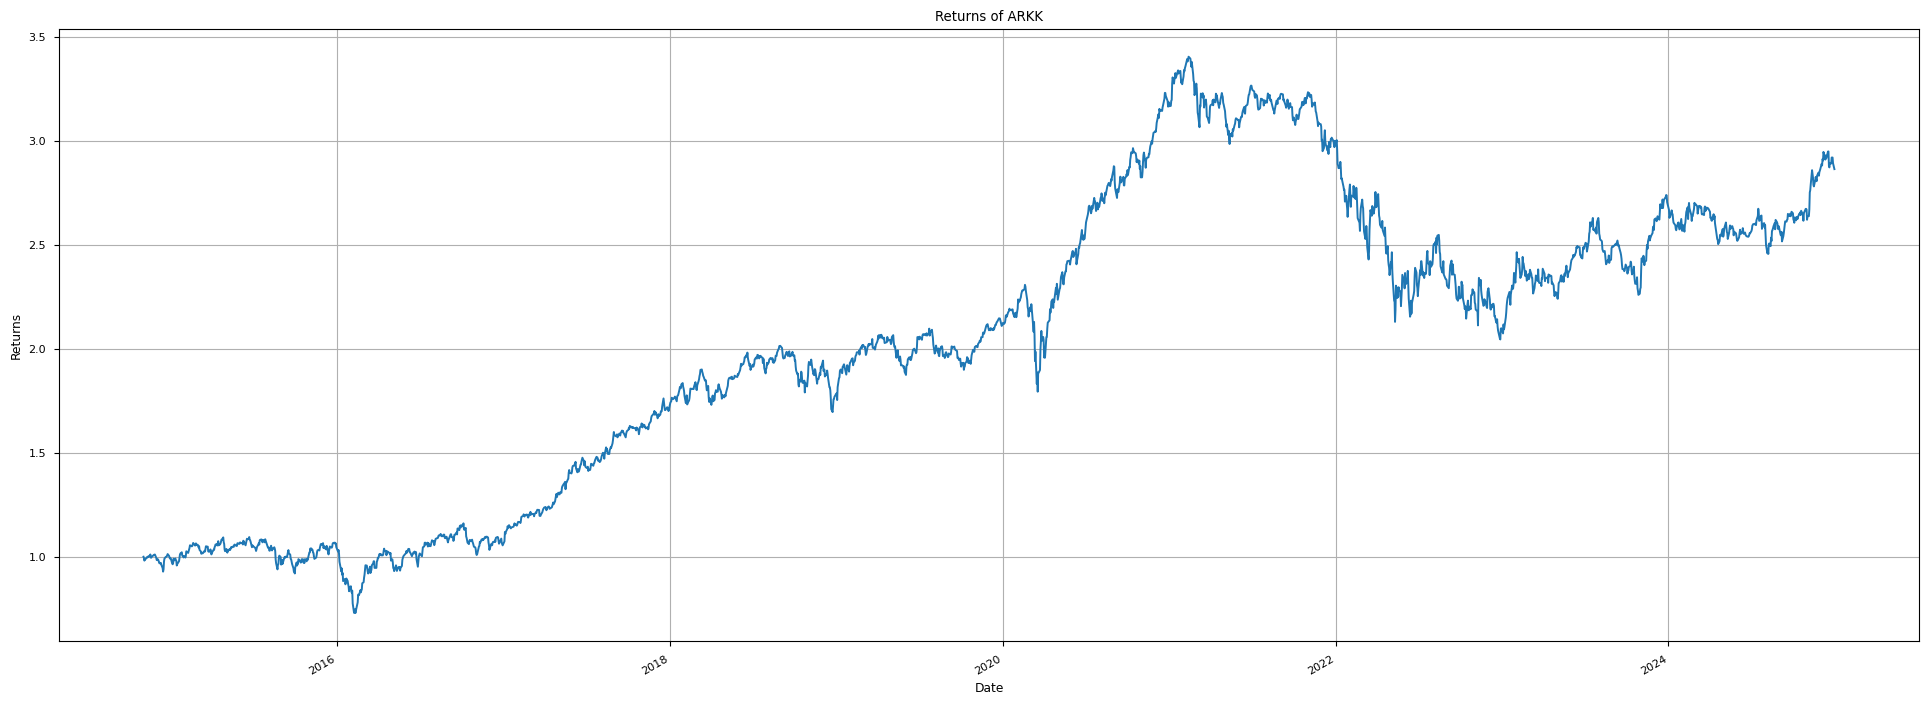

In [319]:
(returns.cumsum() + 1).plot(figsize=(24,9));
plt.ylabel('Returns')
plt.title('Returns of ARKK')
plt.grid(True)
plt.show()

On a strategy Buy & Hold, you can make almost 2 times the initial investment with this product. So in order to be profitable, our strategy must be at least 2 times profitable.

So at this point, we've studied the characteristics of our product and we are ready to implement the mean-reversion strategy. I will use differents implementations of this trading strategy to illustrate the differences between them :
* Simple Moving Average
* Z-score based on MA
* Pair Trading or Statistical Arbitrage

### I. Basic strategy: Moving Average

In [320]:
ma = pd.DataFrame(arkk['Close'])

ma['ma_21'] = prices.rolling(window=21).mean()

ma['ma_63'] = prices.rolling(window=63).mean()

ma['diff'] = ma['Close'] - ma['ma_21']

ma['signal'] = np.where(ma['diff'] < 0, -0.75, 1.5)

In [321]:
figs = (24,9)

r_f = 0.02

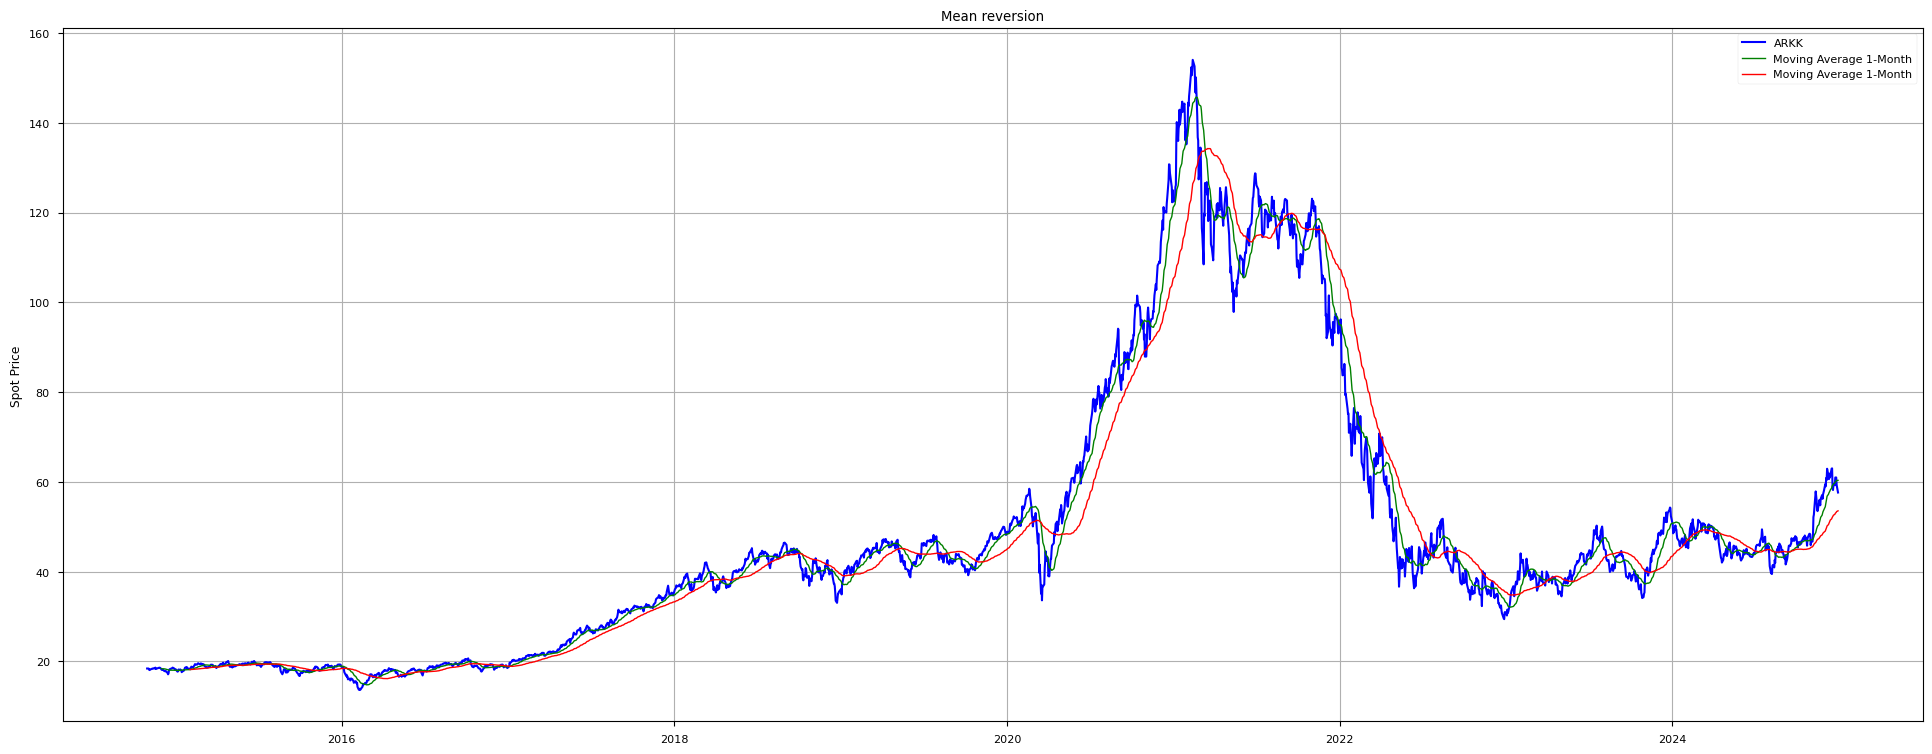

In [322]:
plt.figure(figsize=figs)
plt.plot(prices, label = 'ARKK', color = 'blue', lw = 1.5)
plt.plot(ma['ma_21'], label = 'Moving Average 1-Month', color = 'green', lw = 1)
plt.plot(ma['ma_63'], label = 'Moving Average 1-Month', color = 'red', lw = 1)
plt.ylabel('Spot Price')
plt.title('Mean reversion')
plt.grid(True)
plt.legend(loc=0)
plt.show()

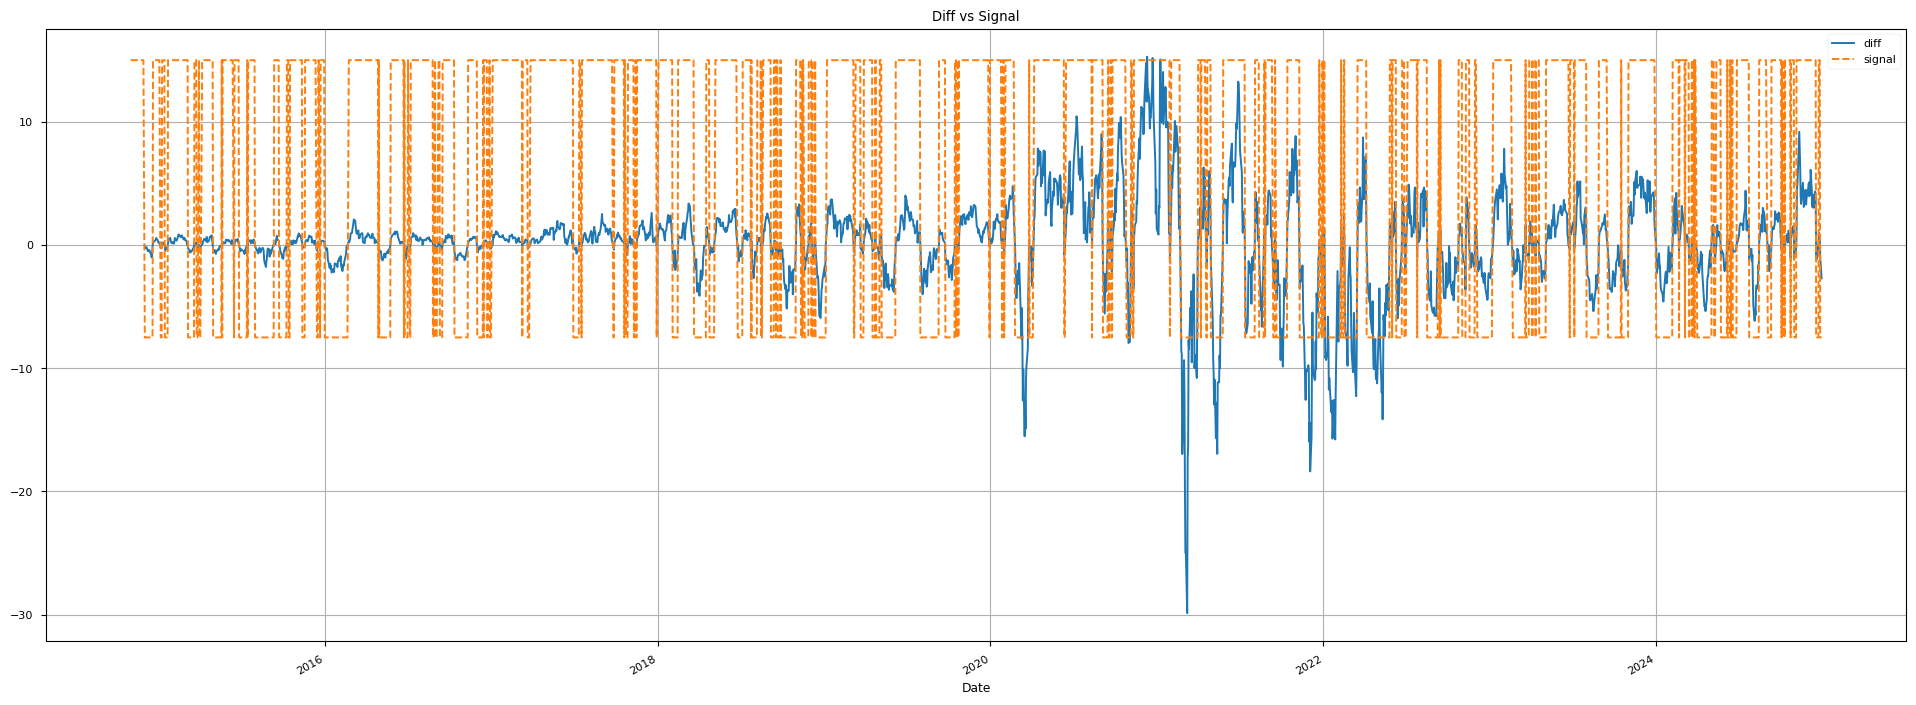

In [323]:
ma['diff'].plot(figsize=figs)
(10*ma['signal']).plot(figsize=figs, linestyle='--')
plt.title("Diff vs Signal")
plt.grid(True)
plt.legend()
plt.show()

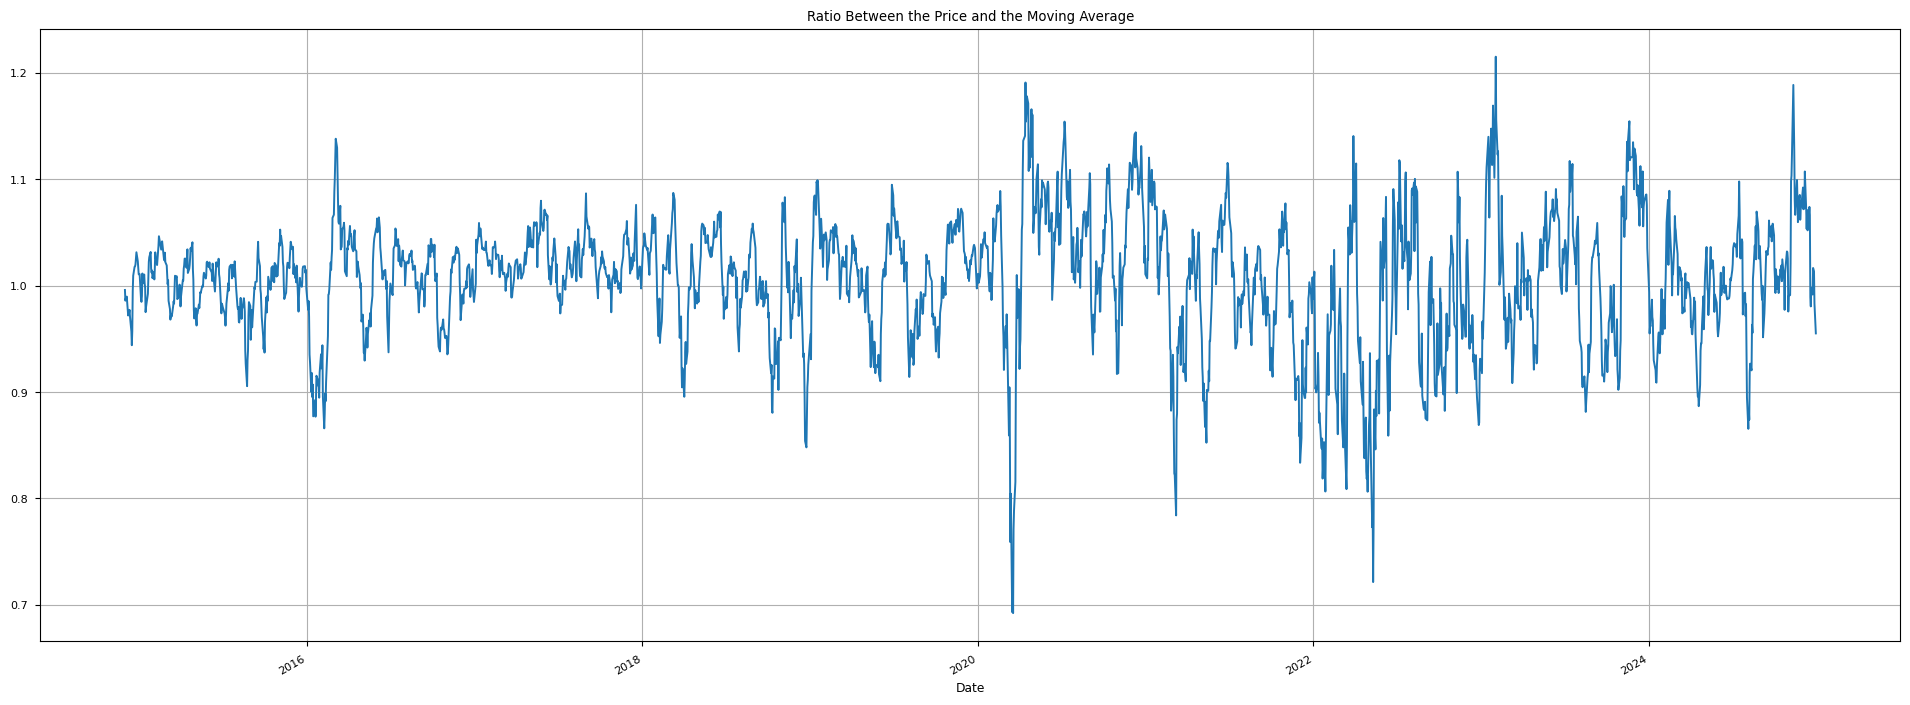

In [324]:
(ma["Close"]/ma["ma_21"] ).plot(figsize=figs)
plt.title("Ratio Between the Price and the Moving Average")
plt.grid(True)
plt.show()

C:\Users\houss\AppData\Local\Temp\ipykernel_7192\1128732409.py:16: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(ma['bh_strategy'], label = 'Buy & Hold Strategy', color = 'red')


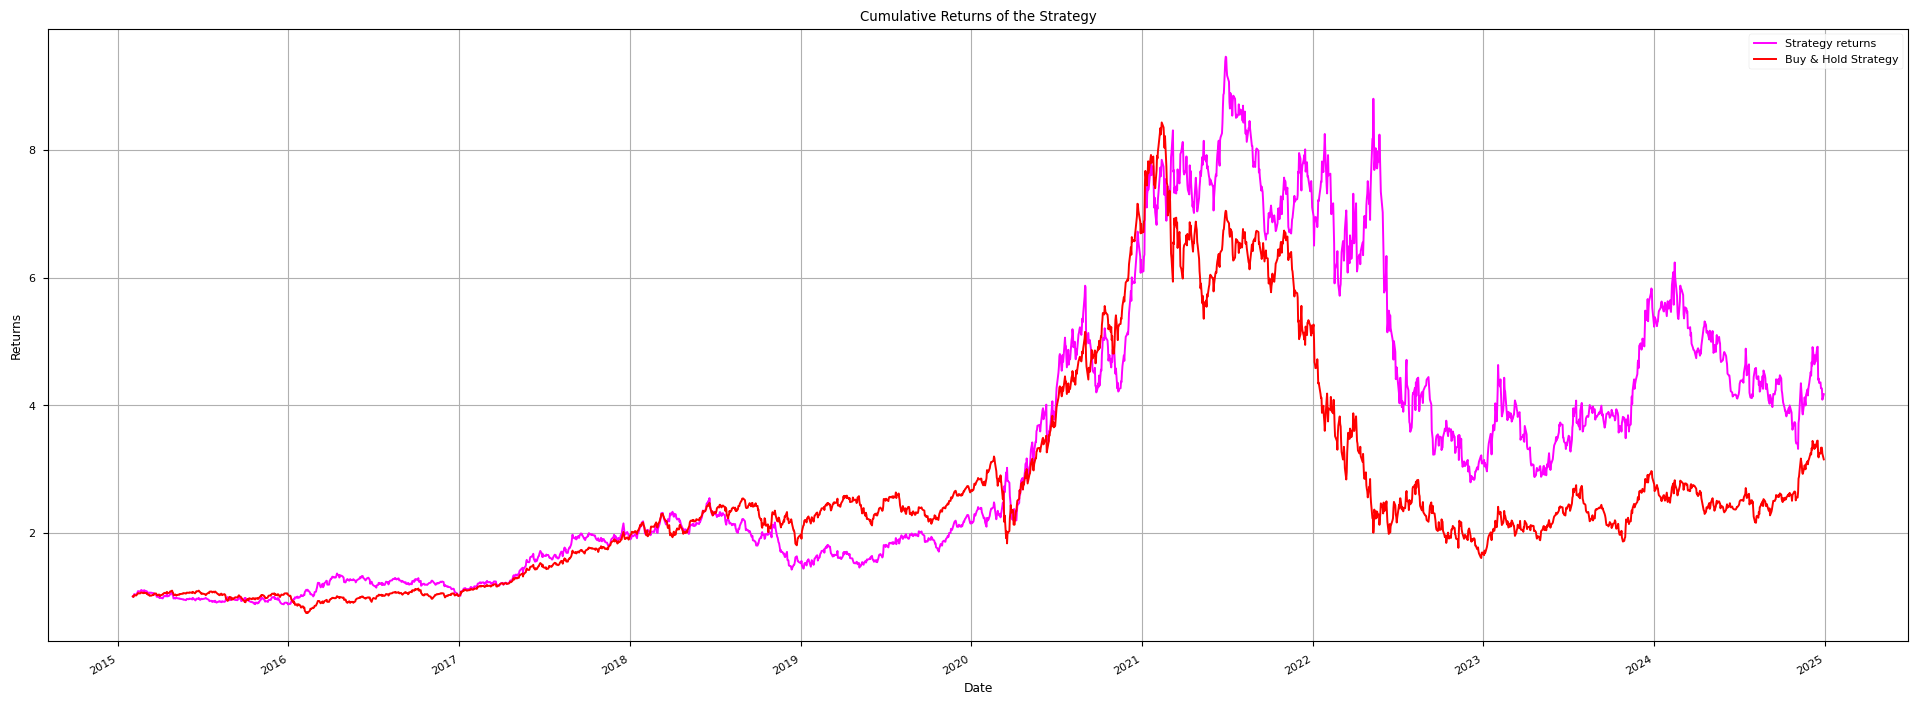

In [325]:
# Backtesting the strategy
# Calculate the daily returns
ma['returns'] = prices.pct_change()

# Calculate the strategy returns
ma['strategy_returns'] = ma['signal'].shift(1) * ma['returns']

# Calculate the cumulative returns
ma=ma.dropna()
ma['cumulative_returns'] = (1 + ma['strategy_returns']).cumprod()

ma['bh_strategy'] = (1 + ma['returns']).cumprod()

# Plot the cumulative returns
ma['cumulative_returns'].plot(figsize = figs, label = 'Strategy returns', color = 'magenta')
plt.plot(ma['bh_strategy'], label = 'Buy & Hold Strategy', color = 'red')
plt.ylabel('Returns')
plt.title("Cumulative Returns of the Strategy")
plt.grid(True)
plt.legend(loc=0)
plt.show()

Here, we can see that the performance of the trading strategy peaks in 2022 and then begins to decline. But with some ajustments within the parameters, the performance of the strategy is improved, but the question remains on the risk of this startegy. However, we can see that the strategy is not profitable enoughugh to be used as a trading strategy. So, let's try another method and see if it's suits better this asset.

In [326]:
sh_1 = (ma['cumulative_returns'].mean() - r_f) / ma['cumulative_returns'].std()

print("Sharpe Ratio of the strategy: ", sh_1)

Sharpe Ratio of the strategy:  1.508573208853309


### II. Z-score strategy

In [327]:
def z_score(x, window):
    return (x - x.rolling(window=window).mean()) / x.rolling(window=window).std()

data = pd.DataFrame()

data['Close'] = prices

data['z-score'] = z_score(prices, 21)

data['ma_21'] = ma['ma_21']

data['std_21'] = prices.rolling(window=21).std()

In [328]:
# Buy order if the z-score is less than n_std (=1)
# Sell order if the z-score is more than n_std (=1)
# Hold if between -1 and 1
n_std= 1
data['signal'] = np.where(data['z-score'] > -n_std, 1.25, np.where(data['z-score'] < n_std, -0.75, 0))

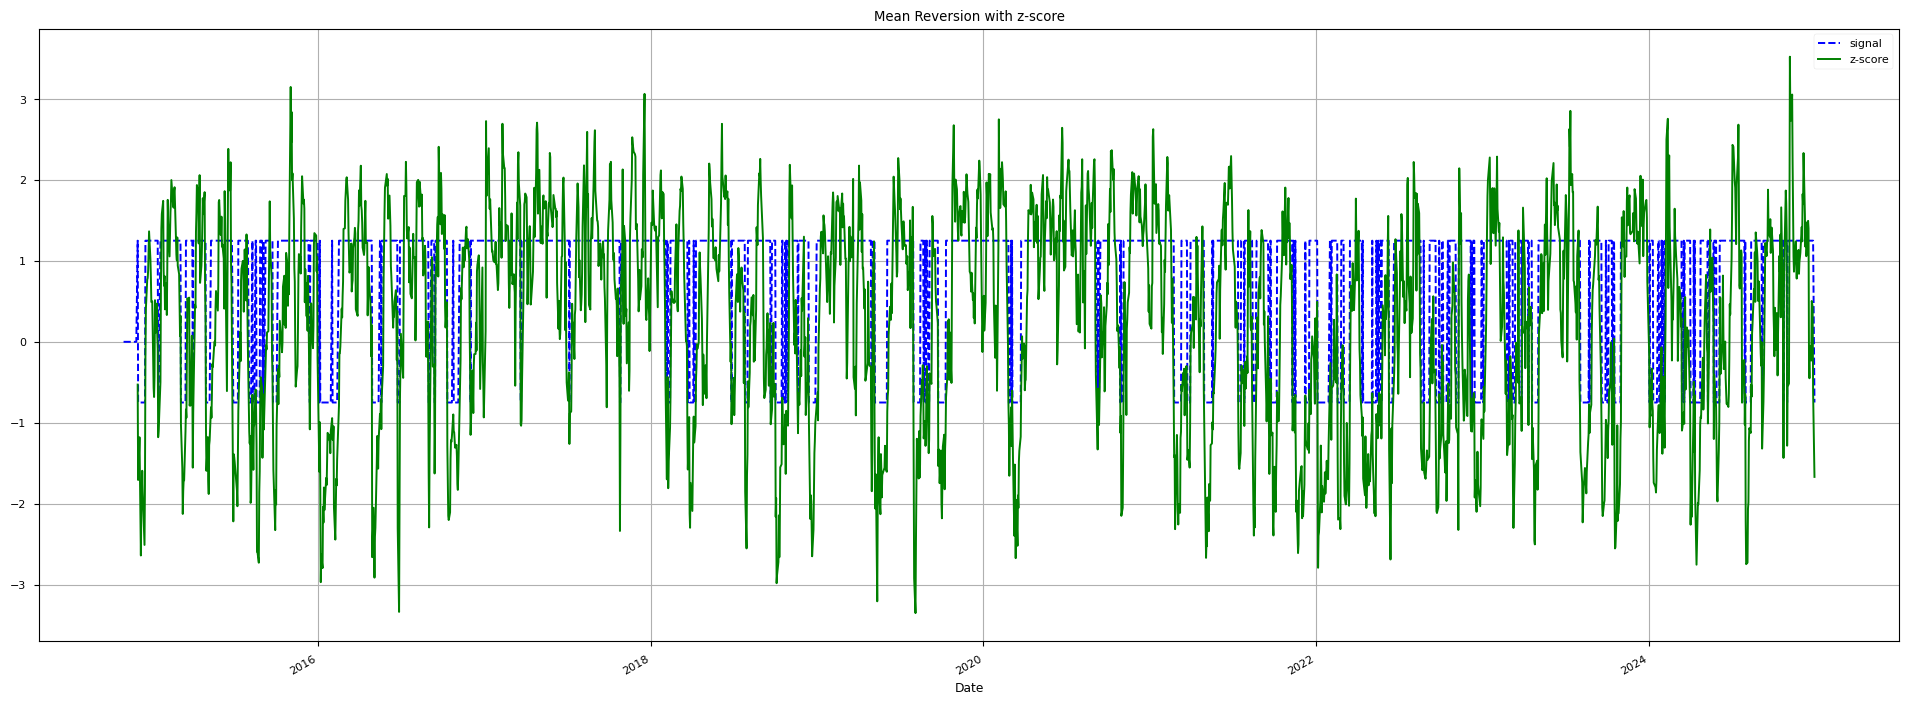

In [329]:
data['signal'].plot(figsize=figs, linestyle="--", color = 'blue')  
data['z-score'].plot(figsize=figs, color='green')         
plt.title("Mean Reversion with z-score")
plt.grid(True)
plt.legend()
plt.show()

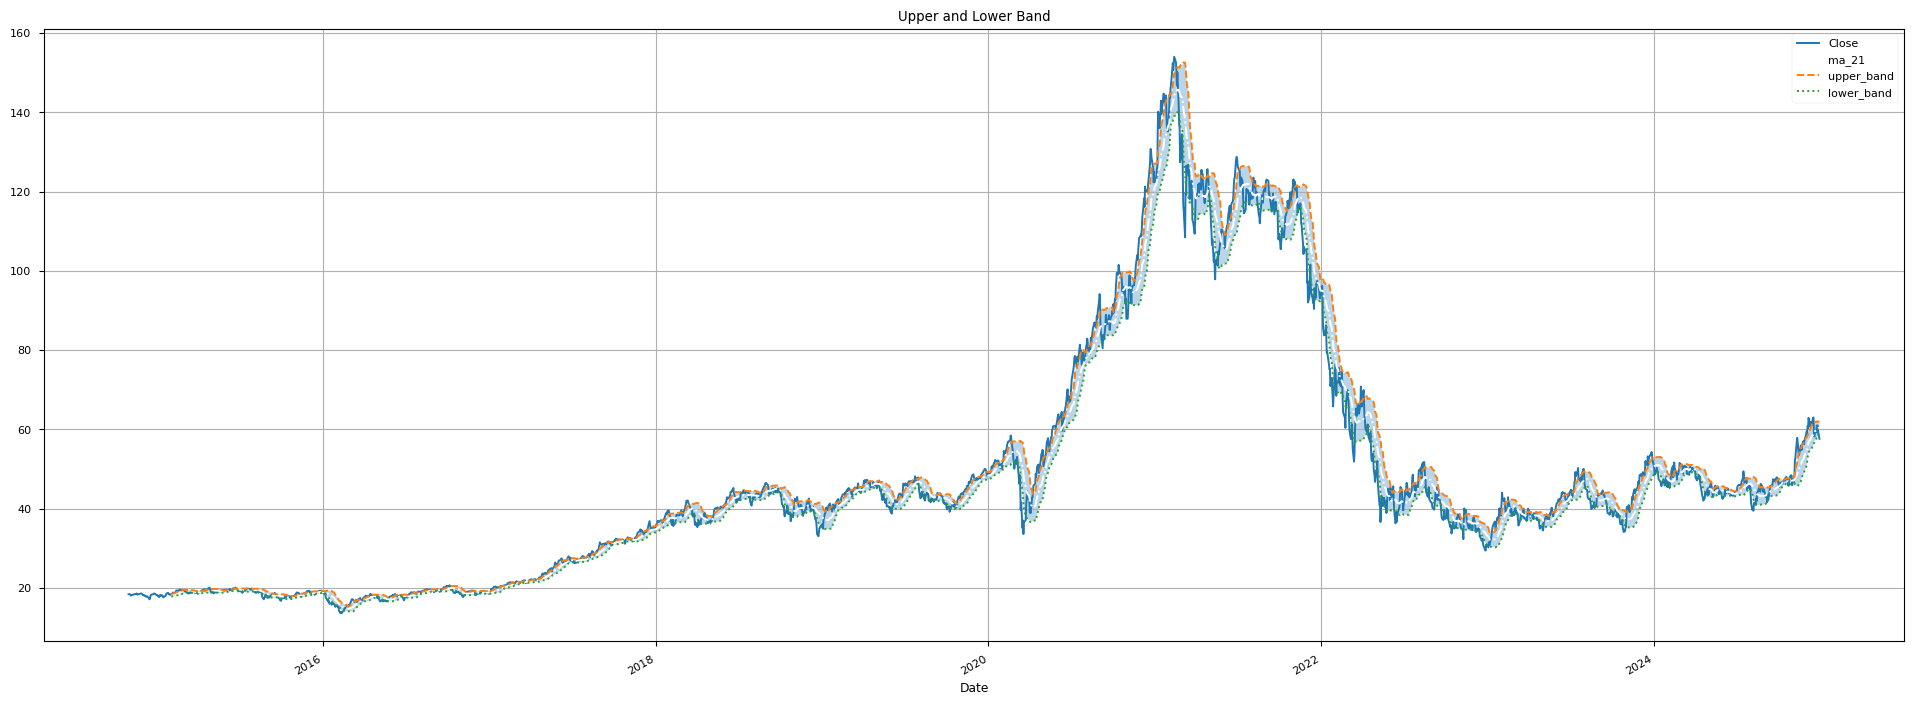

In [330]:
upper_band=data['ma_21']+n_std*data['std_21']
lower_band=data['ma_21']-n_std*data['std_21']

data['Close'].plot(figsize=figs)
data['ma_21'].plot(figsize=figs,linestyle='-.', color="w")
upper_band.plot(linestyle='--',label='upper_band')
lower_band.plot(linestyle=':',label='lower_band')
plt.fill_between(data.index,lower_band, upper_band, alpha=0.3)
plt.title("Upper and Lower Band")
plt.grid(True)
plt.legend()
plt.show()

C:\Users\houss\AppData\Local\Temp\ipykernel_7192\3193451906.py:15: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(data['bh_returns'], label='Buy & Hold Strategy', color = 'red')


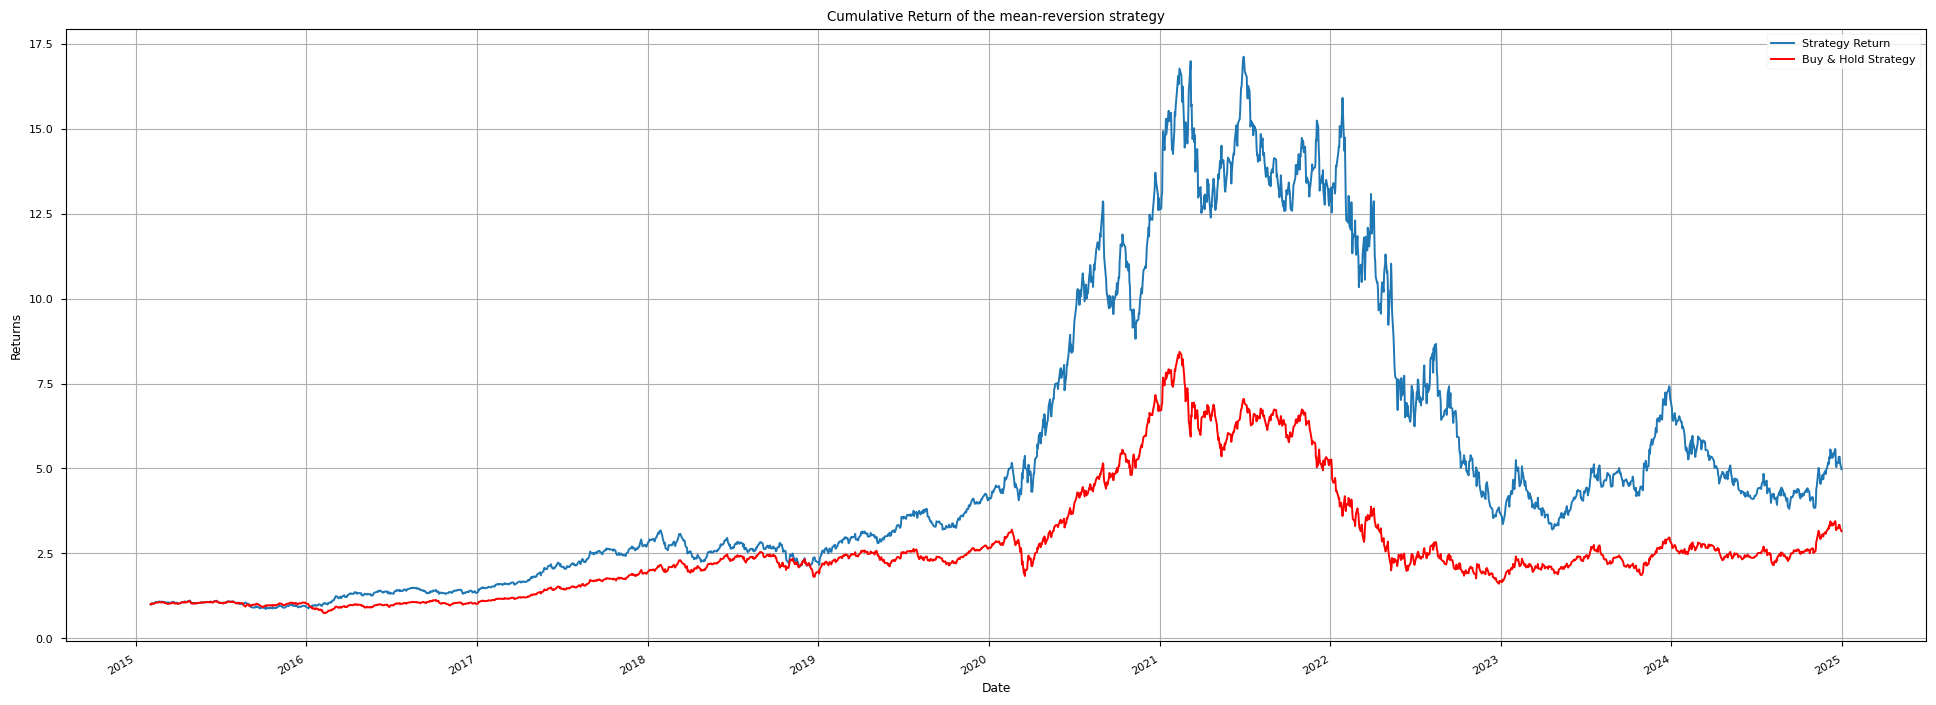

In [331]:
# Calculate the daily returns
data['returns'] = data['Close'].pct_change()

# Calculate the strategy returns
data['strategy_returns'] = data['signal'].shift(1) * data['returns']

# Calculate the cumulative returns
data=data.dropna()
data['cumulative_returns'] = (1 + data['strategy_returns']).cumprod()

data['bh_returns'] = (1 + data['returns']).cumprod()

# Plot the cumulative returns
data['cumulative_returns'].plot(figsize=figs, label = 'Strategy Return')
plt.plot(data['bh_returns'], label='Buy & Hold Strategy', color = 'red')
plt.title("Cumulative Return of the mean-reversion strategy")
plt.ylabel('Returns')
plt.grid(True)
plt.legend(loc=0)
plt.show()

In [332]:
sh_2 = (data['cumulative_returns'].mean() - r_f) / data['cumulative_returns'].std()

print('Sharpe Ratio of the z-score Strategy:', sh_2)

Sharpe Ratio of the z-score Strategy: 1.2139747368771923


This strategy is way more effective that the first one. With the z-score, we can capture more accurately the dynamics of the ETF. But, like the first method, we can see a decline in 2022 but here, the peak is in 2021. The z-score method really outperforms the Buy & Hold strategy so it's a win, but with a Sharpe ratio lower than the Moving average method. So, let go on our last method of mean-reversion, statistical arbitrage between two cointegrated assets.

### III. Statistical arbitrage between two cointegrated assets

For this one, I prefer to use stocks instead of ETFs, that doesn't really affect the returns of the strategy, just a preference of mine. So I'll try to use electonic payments companies, Visa and Mastercard but we need first to verify if they are cointegrated, and for that, I'll use my library ysk_quantlib and the Engle-Granger test.

In [333]:
vs = pd.read_excel('vma.xlsx', sheet_name='Vista', index_col='Date')
mad = pd.read_excel('vma.xlsx', sheet_name='Mastercard', index_col='Date')

In [334]:
data_sta = pd.concat((vs['Close'], mad['Close']), axis=1)

data_sta.columns = ['VS', 'MAD']

data_sta

,VS,MAD
Date,,
2020-01-02,183.872055,294.123230
2020-01-03,182.409683,291.253540
2020-01-06,182.015259,292.029175
2020-01-07,181.534195,291.040405
2020-01-08,184.641678,296.175537
...,...,...
2024-12-23,316.162048,527.345154
2024-12-24,319.580597,534.074524
2024-12-26,319.839752,534.513184


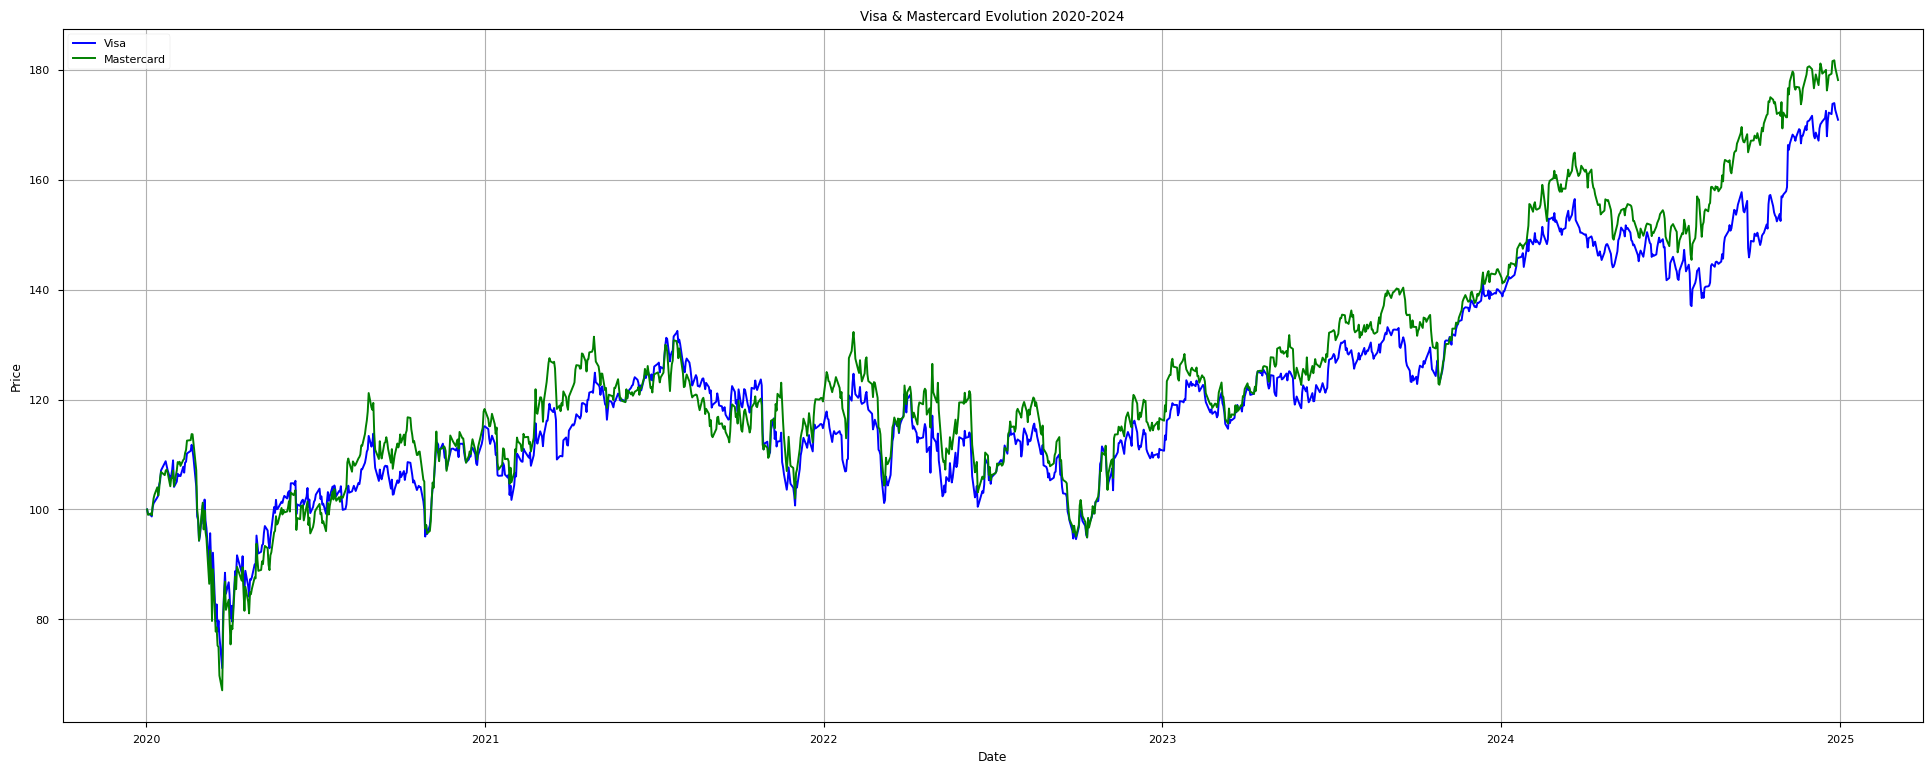

In [335]:
plt.figure(figsize=figs)
plt.plot(normalize(vs), label = 'Visa', color = 'blue')
plt.plot(normalize(mad), label = 'Mastercard', color = 'green')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Visa & Mastercard Evolution 2020-2024')
plt.grid(True)
plt.legend(loc=0)
plt.show()

Just by looking to this graph, you can see a long-term relation between the two stocks which means that there are cointegrated. But just to be sure, we'll use the Engle-Granger test for cointegration and also display a correlation matrix style heat-map.

In [336]:
cointegration_test(data_sta['VS'], data_sta['MAD'])

Test statistic     : -4.6432
p-value            : 0.0007
Critical values    : {'1%': '-3.9052', '5%': '-3.3410', '10%': '-3.0478'}
✅ The series are cointegrated at the 5% level.


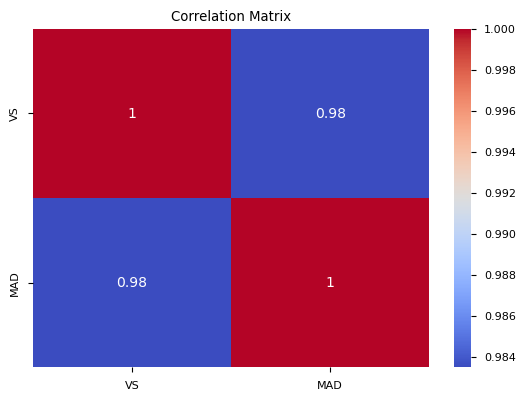

In [337]:
correlation_matrix = data_sta.corr()

# Visualisation en heat map de la matrice de corrélation
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [338]:
ticker_long = 'MAD'
ticker_short = 'VS'

In [339]:
import statsmodels.api as sm

X = data_sta[ticker_short]
Y = data_sta[ticker_long]
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()
hedge_ratio = model.params[1]  


spread = data_sta[ticker_long] - hedge_ratio * data_sta[ticker_short]

C:\Users\houss\AppData\Local\Temp\ipykernel_7192\1594786312.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[1]


In [340]:
window = 21
n_std = .5

In [341]:
zscore = z_score(spread, window)

rolling_mean = spread.rolling(window=window).mean()
rolling_std = spread.rolling(window=window).std()

upper_band = rolling_mean + n_std * rolling_std
lower_band = rolling_mean - n_std * rolling_std

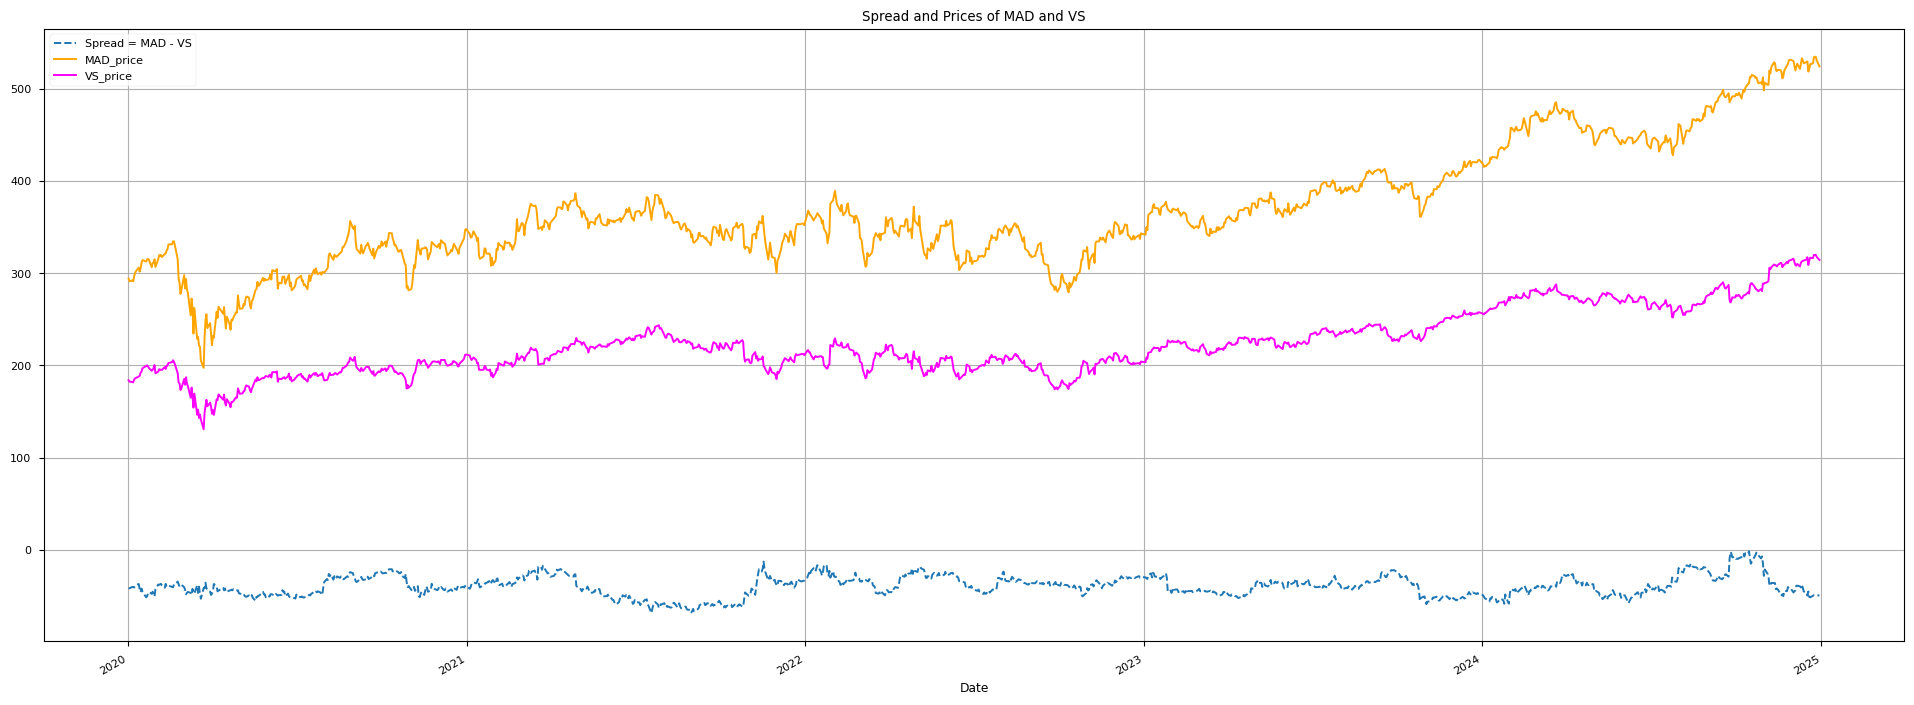

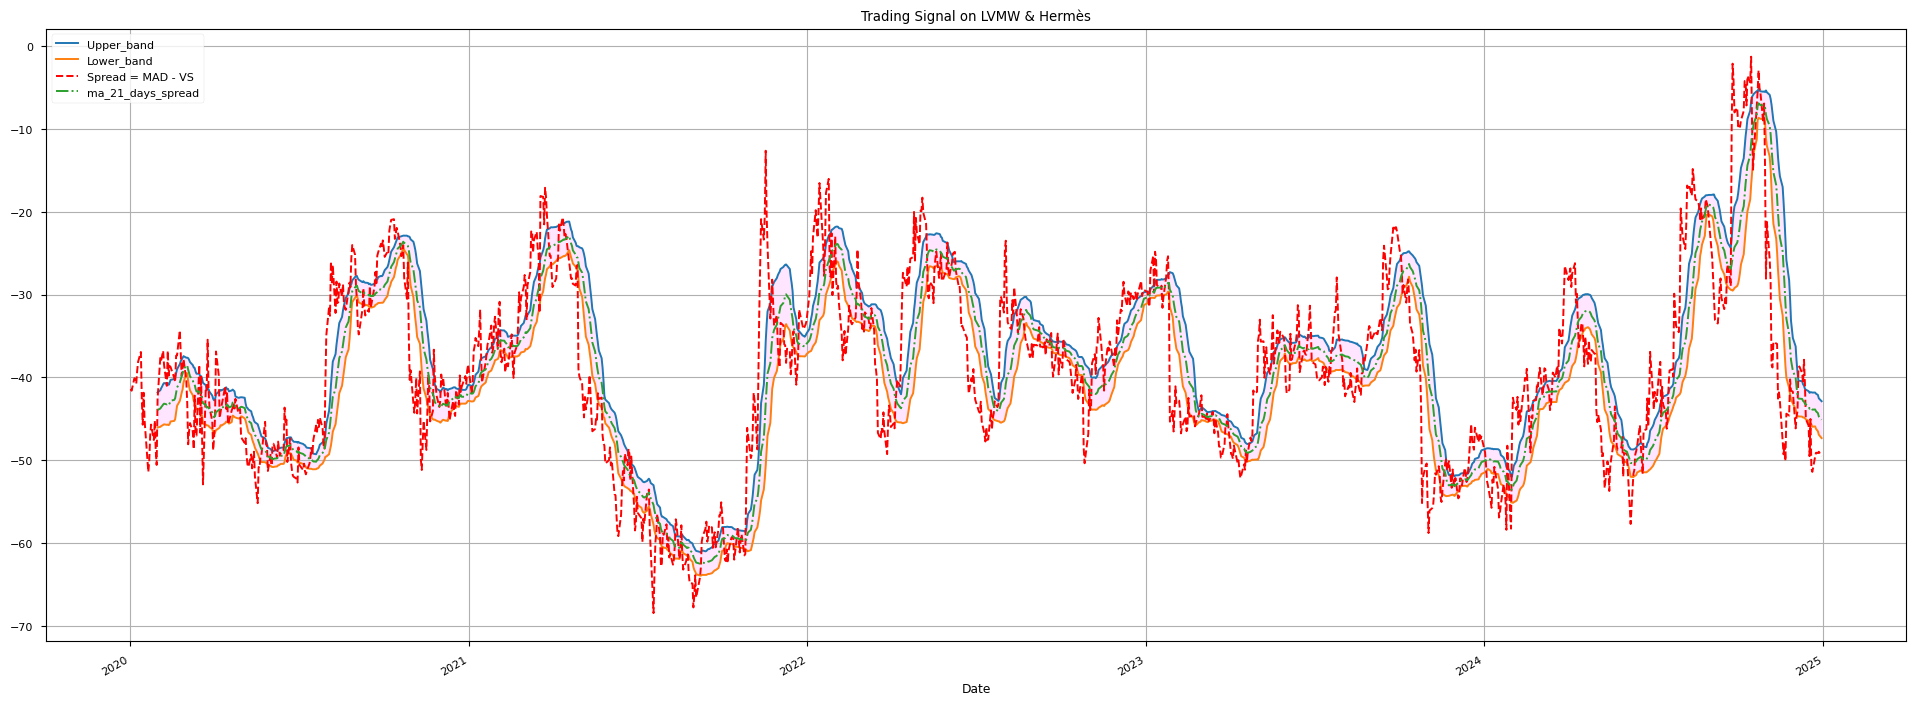

In [342]:
plt.figure(figsize = figs)
spread.plot(label='Spread = '+ticker_long+' - '+ ticker_short,linestyle='--')
data_sta[ticker_long].plot(label=ticker_long+'_price', color = 'orange')
data_sta[ticker_short].plot(label=ticker_short+'_price', color = 'magenta')
plt.title("Spread and Prices of {0} and {1}".format(ticker_long,ticker_short))
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize = figs)
upper_band.plot(label='Upper_band')
lower_band .plot(label='Lower_band')
spread.plot(label = 'Spread = '+ticker_long+' - '+ ticker_short,linestyle='--', color='red')
rolling_mean.plot(label = 'ma_21_days_spread', linestyle = '-.')
plt.fill_between(data_sta.index,lower_band, upper_band, alpha=0.1, color = 'magenta')
plt.title('Trading Signal on LVMW & Hermès')
plt.grid(True)
plt.legend()
plt.show()

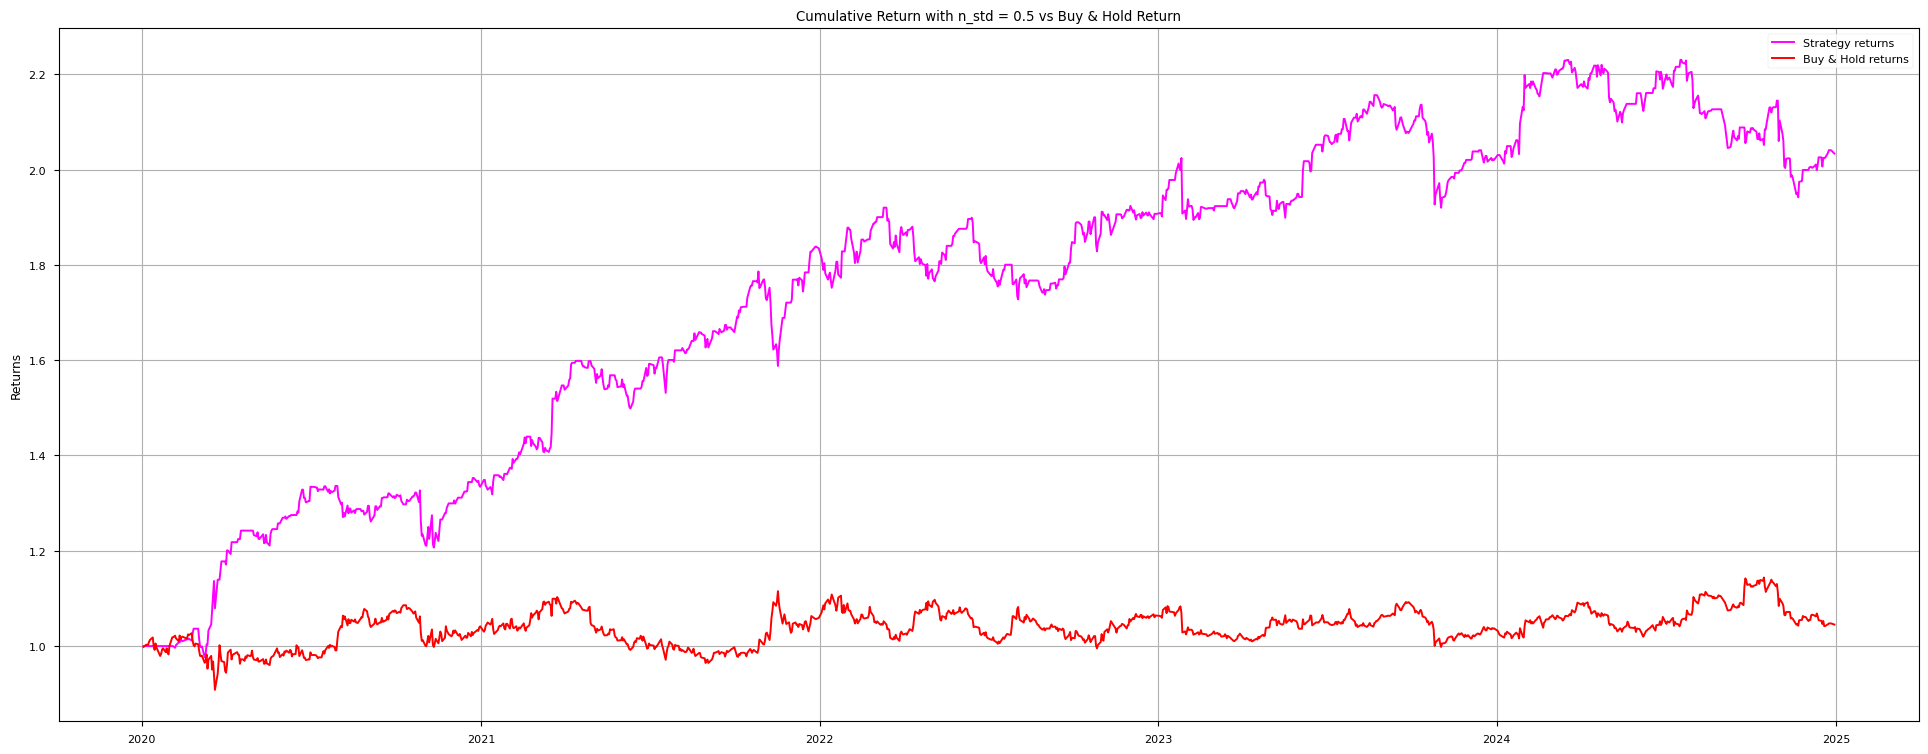

In [343]:
# Long position if z-score < -n_std
# Short position if z-score > n_std

signal = np.where(zscore < -n_std, 1.5, np.where(zscore > n_std, -1, 0))
signal = pd.Series(signal, index=data_sta.index)

returns = data_sta[ticker_long].pct_change() - data_sta[ticker_short].pct_change()

strategy_returns = signal.shift(1) * returns

cumulative_returns = (1 + strategy_returns).cumprod()

bh_returns = (1 + returns).cumprod()

# Plot the cumulative returns
plt.figure(figsize = figs)
plt.plot(cumulative_returns, label='Strategy returns', color = 'magenta')
plt.plot(bh_returns, label='Buy & Hold returns', color = 'red')
plt.ylabel('Returns')
plt.title("Cumulative Return with n_std = {0} vs Buy & Hold Return".format(n_std))
plt.grid(True)
plt.legend(loc=0)
plt.show()

In [344]:
sh_3 = (cumulative_returns.mean() - r_f) / cumulative_returns.std()

print('Sharpe ratio of the Stat Arbitrage:', sh_3)

Sharpe ratio of the Stat Arbitrage: 5.167235385388227


Compared to our previous strategies, this strategy appears to be the least profitable, but it has the best Sharpe ratio. However, this is a little too high, so I will have to test it with another pair of assets to see if it is not an overadjusted result.

In [345]:
from statsmodels.tsa.stattools import coint
from itertools import combinations

start, end = '2020-01-01', '2024-12-31'
alpha = 0.05

tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA', 'PYPL', 'ADBE', 'INTC', 'CSCO', 'NFLX', 'PEP', 'KO', 'MCD', 'DIS', 'V', 'JPM', 'WMT', 'MA']

data = yf.download(tickers, start=start, end=end, auto_adjust=True)['Close'].dropna(axis=1)

# Résultat
results = []

for a, b in combinations(data.columns, 2):
    series_a = data[a]
    series_b = data[b]
    score, pvalue, _ = coint(series_a, series_b)
    results.append({'pair': (a, b), 'pvalue': pvalue})


results_df = pd.DataFrame(results).sort_values('pvalue')

coint_pairs = results_df[results_df['pvalue'] < alpha]
print(f"\nPaires cointégrées (p < {alpha}):\n", coint_pairs)

[*********************100%***********************]  20 of 20 completed



Paires cointégrées (p < 0.05):
              pair    pvalue
143       (MA, V)  0.000583
122      (JPM, V)  0.005040
113     (JPM, MA)  0.005875
81    (DIS, PYPL)  0.009774
86   (GOOGL, JPM)  0.021339
139    (MA, NVDA)  0.022870
100    (INTC, KO)  0.030985
144     (MA, WMT)  0.032902
167     (MSFT, V)  0.044309


I already used the pair (MA,V) so for this one, I'm gonna go with the pair (GOOGL, JPM). It's really intersting to me to study this combinaison of stocks because I wouldn't imagine in a million years that those two were cointegrated in alpha = 5%.

In [346]:
start, end = '2020-01-01', '2024-12-31'

In [347]:
googl = yf.download('GOOGL', start=start, end=end, auto_adjust=True)
jpm = yf.download('JPM', start=start, end=end, auto_adjust=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [348]:
gg_jp = pd.concat((googl['Close'], jpm['Close']), axis=1)

gg_jp.columns = ['GOOGL', 'JPM']

gg_jp

,GOOGL,JPM
Date,,
2020-01-02,68.026024,120.154694
2020-01-03,67.670158,118.569092
2020-01-06,69.473846,118.474815
2020-01-07,69.339645,116.460648
2020-01-08,69.833183,117.369171
...,...,...
2024-12-23,194.171036,234.583115
2024-12-24,195.647552,238.440506
2024-12-26,195.138748,239.257263


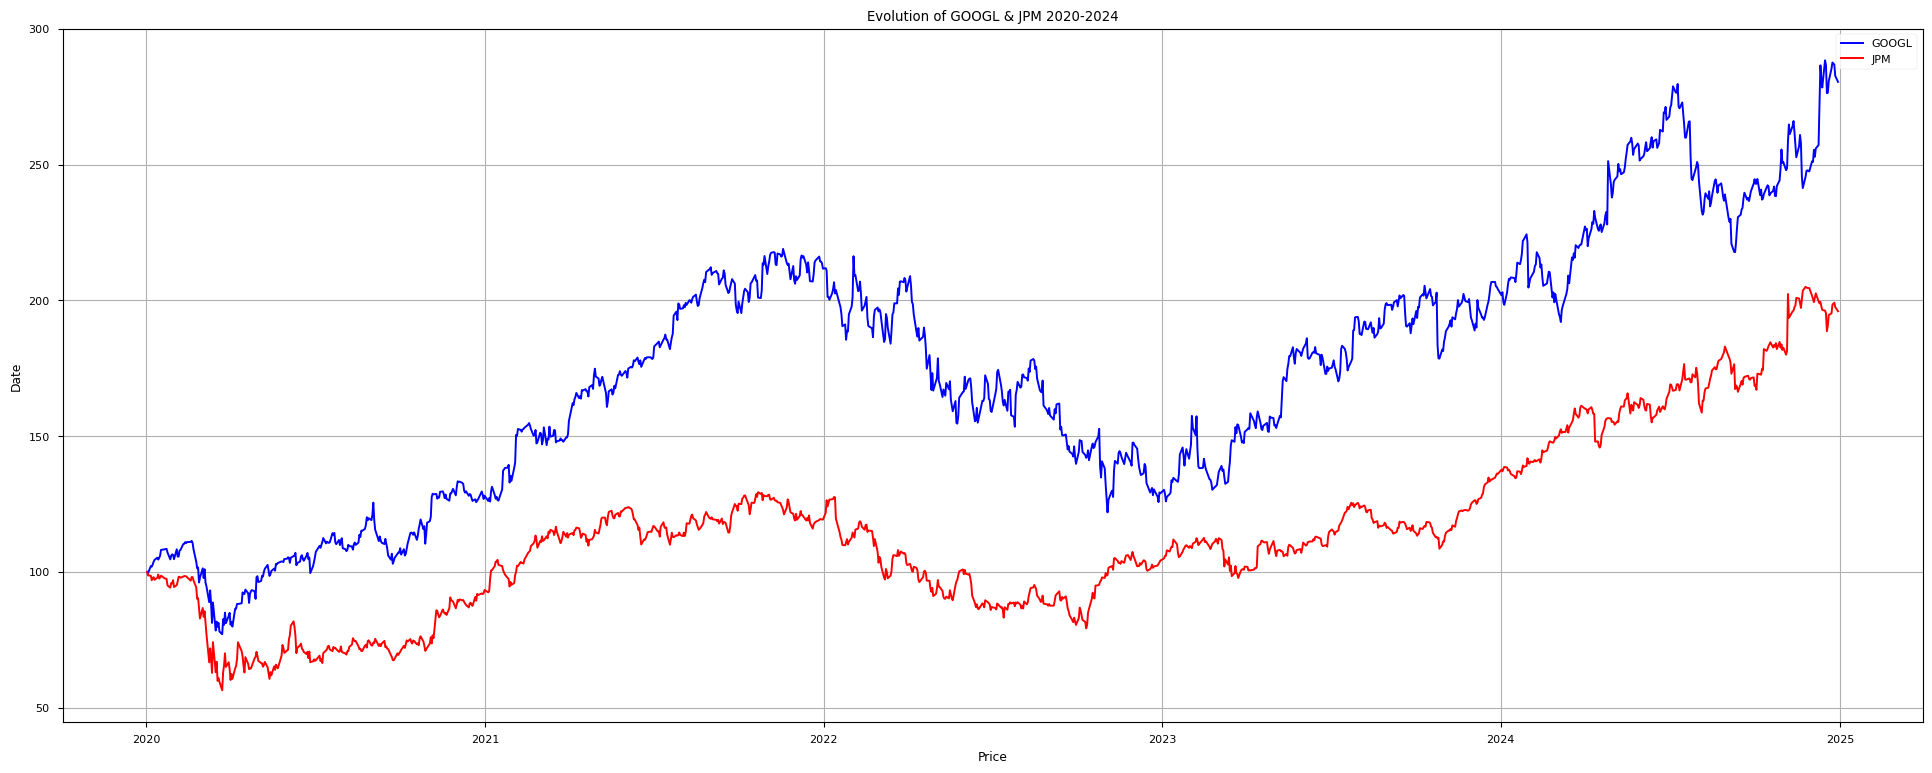

In [349]:
plt.figure(figsize=figs)
plt.plot(normalize(googl), label='GOOGL', color='blue')
plt.plot(normalize(jpm), label='JPM', color='red')
plt.xlabel('Price')
plt.ylabel('Date')
plt.title('Evolution of GOOGL & JPM 2020-2024')
plt.grid(True)
plt.legend(loc=0)
plt.show()

In [350]:
cointegration_test(gg_jp['GOOGL'], gg_jp['JPM'], alpha=0.05, verbose=True)

Test statistic     : -3.6481
p-value            : 0.0213
Critical values    : {'1%': '-3.9052', '5%': '-3.3410', '10%': '-3.0478'}
✅ The series are cointegrated at the 5% level.


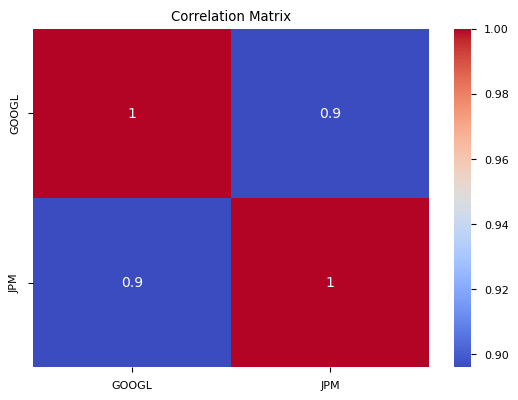

In [351]:
correlation_matrix = gg_jp.corr()

# Visualisation en heat map de la matrice de corrélation
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [352]:
stock_long = 'JPM'
stock_short = 'GOOGL'

In [353]:
X = gg_jp[stock_short]
Y = gg_jp[stock_long]
X = sm.add_constant(X)

model_2 = sm.OLS(Y, X).fit()
hedge_ratio_2 = model_2.params[1]  


spread_2 = gg_jp[stock_long] - hedge_ratio_2 * gg_jp[stock_short]

C:\Users\houss\AppData\Local\Temp\ipykernel_7192\3001928243.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio_2 = model_2.params[1]


In [354]:
zscore_2 = z_score(spread_2, window)

rolling_mean_2 = spread_2.rolling(window=window).mean()
rolling_std_2 = spread_2.rolling(window=window).std()

upper_band_2 = rolling_mean_2 + n_std * rolling_std_2
lower_band_2 = rolling_mean_2 - n_std * rolling_std_2

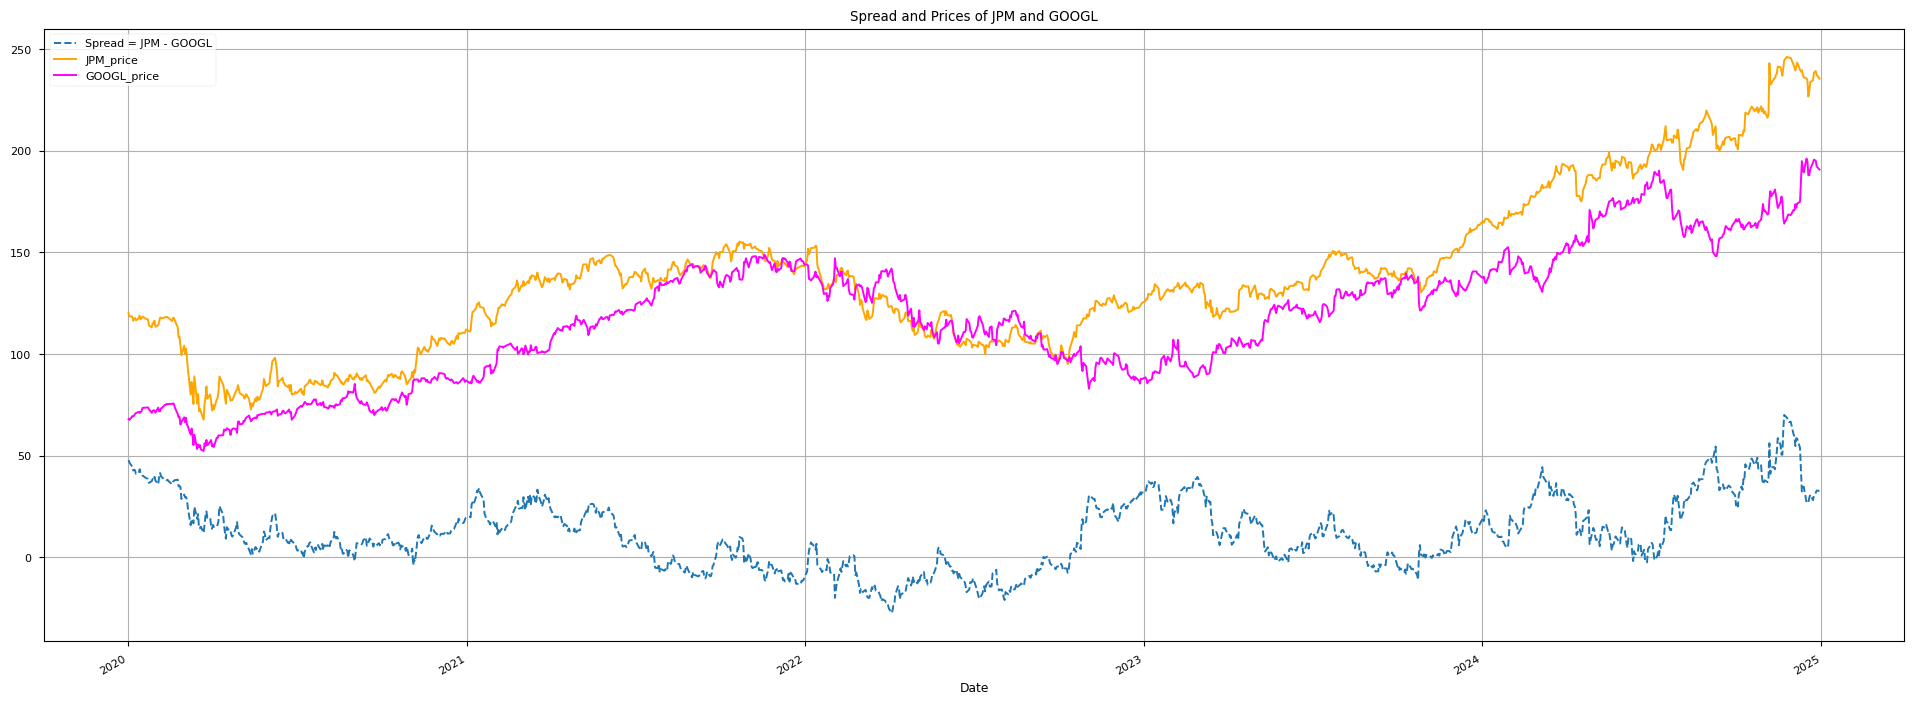

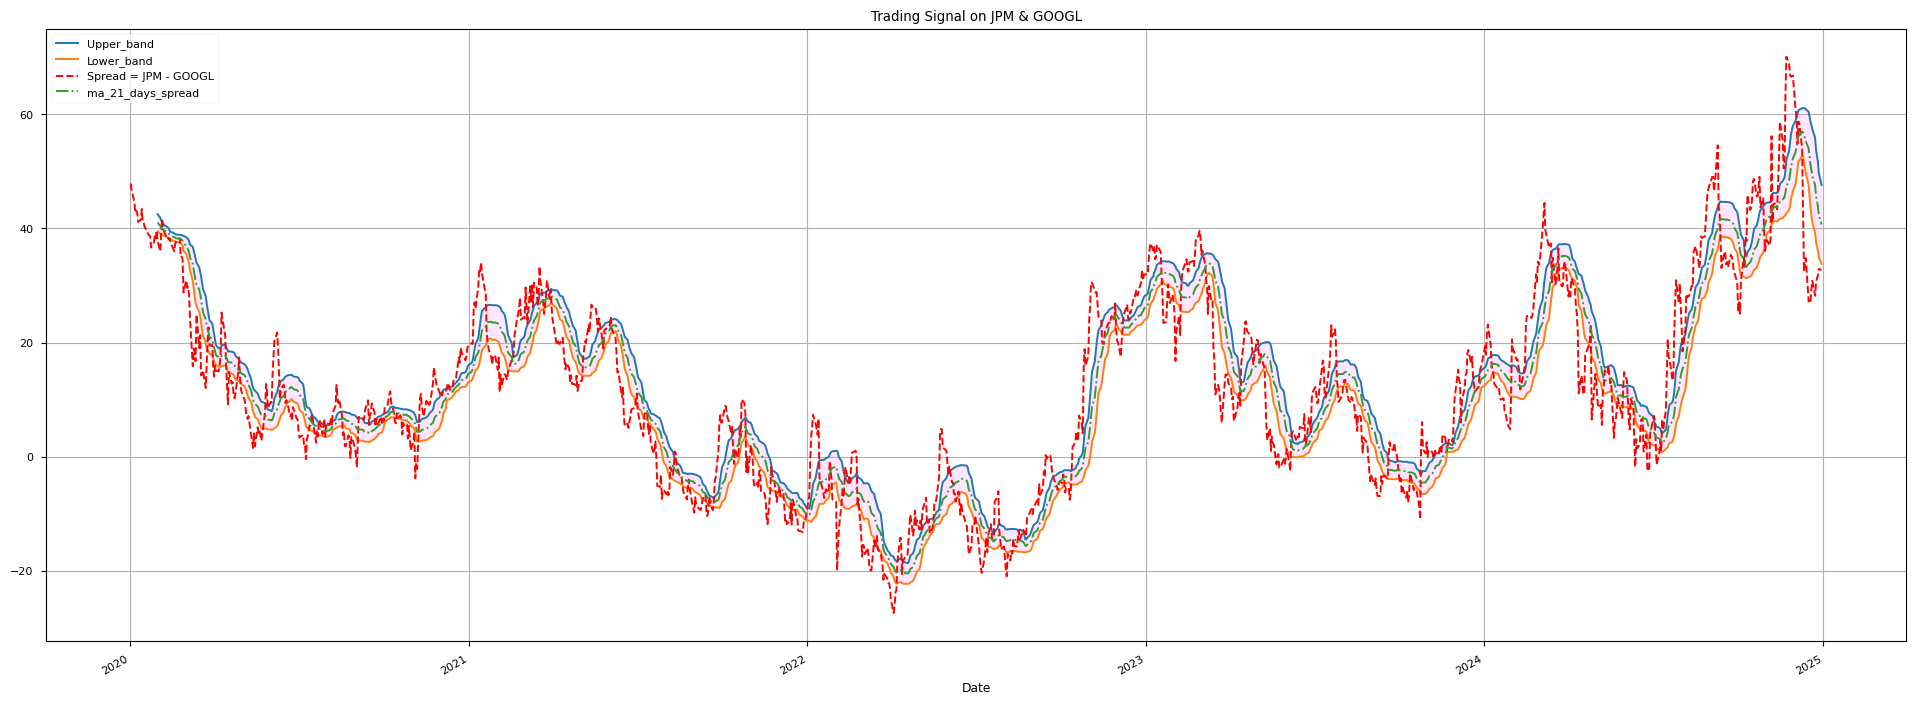

In [355]:
plt.figure(figsize = figs)
spread_2.plot(label='Spread = '+stock_long+' - '+ stock_short, linestyle='--')
gg_jp[stock_long].plot(label=stock_long+'_price', color = 'orange')
gg_jp[stock_short].plot(label=stock_short+'_price', color = 'magenta')
plt.title("Spread and Prices of {0} and {1}".format(stock_long, stock_short))
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize = figs)
upper_band_2.plot(label='Upper_band')
lower_band_2.plot(label='Lower_band')
spread_2.plot(label = 'Spread = '+stock_long+' - '+ stock_short, linestyle='--', color='red')
rolling_mean_2.plot(label = 'ma_21_days_spread', linestyle = '-.')
plt.fill_between(gg_jp.index, lower_band_2, upper_band_2, alpha=0.1, color = 'magenta')
plt.title('Trading Signal on {0} & {1}'.format(stock_long, stock_short))
plt.grid(True)
plt.legend()
plt.show()

In [356]:
n_std = 1.5

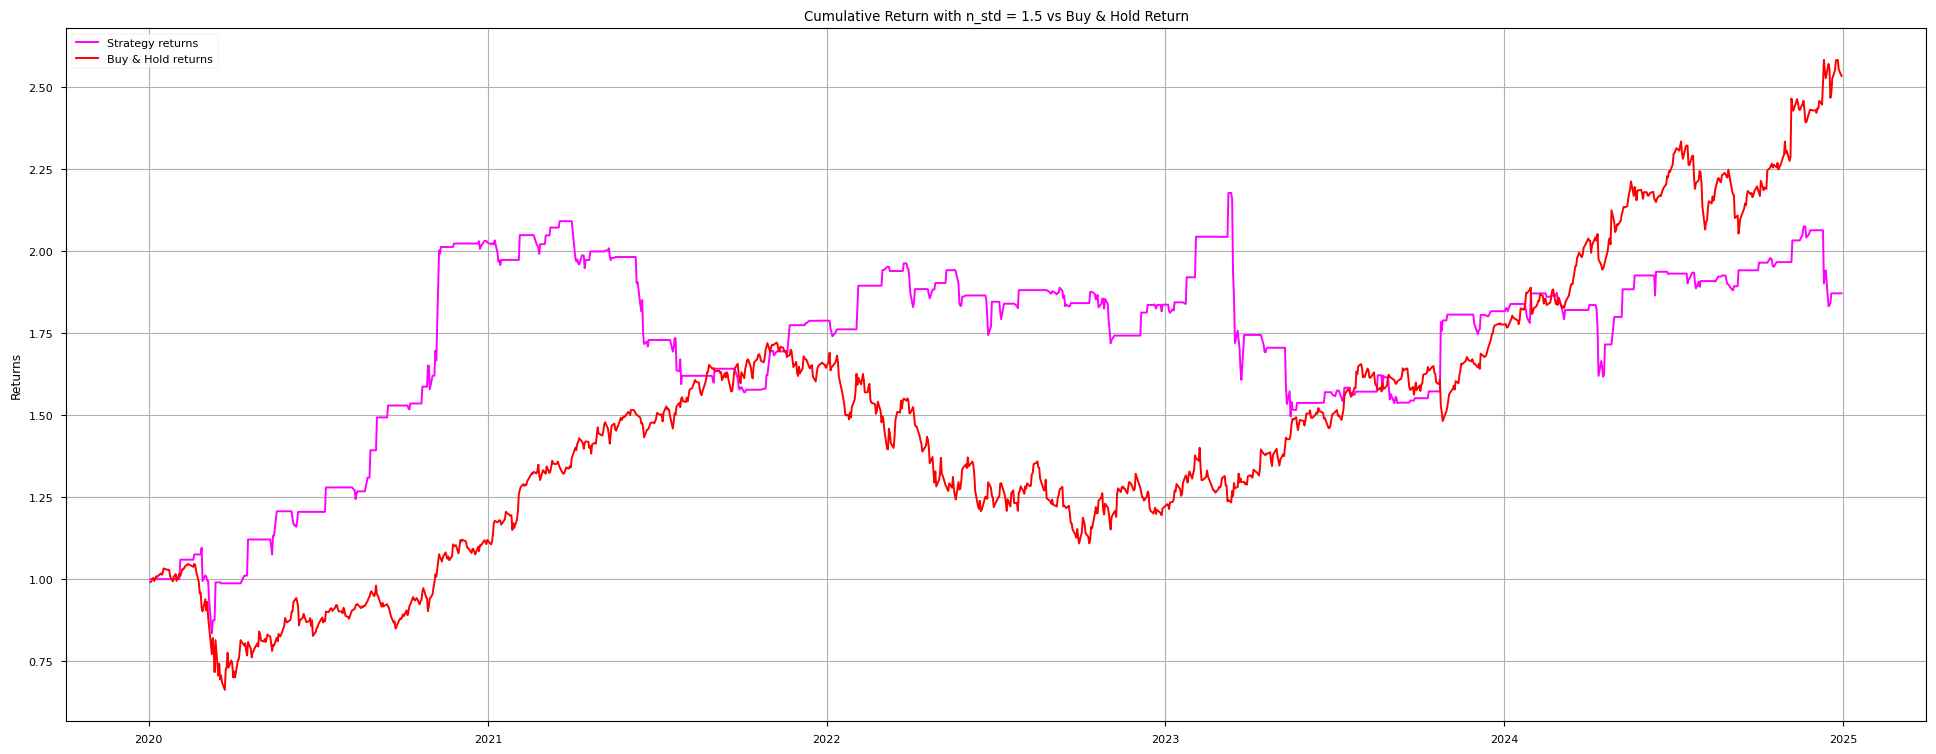

In [368]:
# Long position if z-score < -n_std
# Short position if z-score > n_std

signal_2 = np.where(zscore_2 < -n_std, 1.5, np.where(zscore_2 > n_std, -0.5, 0))
signal_2 = pd.Series(signal_2, index=gg_jp.index)

returns_2 = gg_jp[stock_long].pct_change() - gg_jp[stock_short].pct_change()

returns_bh_2 = 0.5 * (gg_jp[stock_long].pct_change() + gg_jp[stock_short].pct_change())

strategy_returns_2 = signal_2.shift(1) * returns_2

cumulative_returns_2 = (1 + strategy_returns_2).cumprod()

bh_returns_2 = (1 + returns_bh_2).cumprod()

# Plot the cumulative returns
plt.figure(figsize = figs)
plt.plot(cumulative_returns_2, label='Strategy returns', color = 'magenta')
plt.plot(bh_returns_2, label='Buy & Hold returns', color = 'red')
plt.ylabel('Returns')
plt.title("Cumulative Return with n_std = {0} vs Buy & Hold Return".format(n_std))
plt.grid(True)
plt.legend(loc=0)
plt.show()

In [369]:
sh_4 = (cumulative_returns_2.mean() - r_f) / cumulative_returns_2.std()

print('Sharpe Ratio of the Strategy:', sh_4)

sh_bh_4 = (bh_returns_2.mean() - r_f) / bh_returns_2.std()

print('Sharpe Ratio of the Buy & Hold Strategy:', sh_bh_4)

Sharpe Ratio of the Strategy: 6.067857587274211
Sharpe Ratio of the Buy & Hold Strategy: 3.4459683123882345
